# Random Forest test (How robust to correlated features)

In [1]:
import numpy as np
import scipy 
import sklearn 
import matplotlib 
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegressionCV

In [18]:
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :]
Y = iris.target

In [20]:
# Get training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [19]:
forest = RandomForestClassifier(n_estimators = 4000, bootstrap = True, oob_score = True, n_jobs = 2)

In [22]:
# fit the forest on the training data
forest1 = forest.fit(X_train, y_train)
forest1.score(X_test, y_test)

0.97999999999999998

In [24]:
# get feature importances
importance = forest1.feature_importances_
importance

array([ 0.09999137,  0.03807949,  0.41693711,  0.44499204])

## Add a new column which is a production of one of the columns by a value

In [33]:
New_col = X[:,2] * 5
X_new = np.c_[X,New_col];

In [34]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, Y, test_size=0.33, random_state=42)

In [35]:
# fit the forest on the training data
forest2 = forest.fit(X_train_new, y_train_new)
forest2.score(X_test_new, y_test_new)

0.97999999999999998

In [36]:
# get feature importances
importance_new = forest2.feature_importances_
importance_new

array([ 0.06787674,  0.02854143,  0.28529627,  0.32753233,  0.29075324])

## Add two new columns which is a production of one of the columns by a value

In [38]:
New_col_2 = X[:,1] * 0.5
X_new2 = np.c_[X_new,New_col_2];

In [39]:
X_train_new2, X_test_new2, y_train_new2, y_test_new2 = train_test_split(X_new2, Y, test_size=0.33, random_state=42)

In [40]:
# fit the forest on the training data
forest3 = forest.fit(X_train_new2, y_train_new2)
forest3.score(X_test_new2, y_test_new2)

0.97999999999999998

In [41]:
# get feature importances
importance_new2 = forest3.feature_importances_
importance_new2

array([ 0.08379165,  0.03167401,  0.27449177,  0.30564257,  0.27341225,
        0.03098775])

## Add five new columns which all are linear combinations of one of the columns (dominant feature)

In [45]:
m = [1,-1,2,0.5,10];
b = [0.5,2,0.1,-5,1];

X_mod = X;

for i in range(0,5):
    New_col = X[:,3] * m[i] + b[i]
    X_mod = np.c_[X_mod,New_col];

In [46]:
X_train_mod, X_test_mod, y_train_mod, y_test_mod = train_test_split(X_mod, Y, test_size=0.33, random_state=42)

In [47]:
# fit the forest on the training data
forest_mod = forest.fit(X_train_mod, y_train_mod)
forest_mod.score(X_test_mod, y_test_mod)

0.97999999999999998

In [48]:
# get feature importances
importance_mod = forest_mod.feature_importances_
importance_mod

array([ 0.01770515,  0.02365266,  0.15736224,  0.13253585,  0.13453893,
        0.13055569,  0.13862096,  0.13386638,  0.13116213])

#### So, what I concluded from the past three parts is that RF will find the correlated features with same level of importance. But as long as the number of correlated features are huge comparing to the total number of features (5 correlated added + 4 since beginning), in RF output, the dominant features order might be changed. 

## In case of bigger feature space

In [95]:
# Load Data

df = pd.read_csv('breast-cancer.csv',header=None)
col_names = pd.read_csv('field_names.txt',header=None)
df.columns = col_names[0]

In [96]:
# Initialize random forest
forest = RandomForestClassifier(n_estimators = 4000, bootstrap = True, oob_score = True, n_jobs = 2)

In [97]:
# Get training and test sets
train, test = train_test_split(df, test_size = 0.33)

In [98]:
# get training and test features and dependent
train_features = train.iloc[:, 2:]
train_y = train.iloc[:, 1]
test_features = test.iloc[:, 2:]
test_y = test.iloc[:, 1]

# Dominant feature is column No. 24 

In [99]:
# since there are almost twice as many benign instances as cancer instances
# here I'm oversampling the cancer instances to make the classes even
ros = RandomOverSampler()
train_features_resampled, train_y_resampled = ros.fit_sample(train_features, train_y)

In [100]:
New_col = train_features_resampled[:,22] * 0.5
X_train = np.c_[train_features_resampled,New_col];

In [101]:
# fit the forest on the training data
forest_L = forest.fit(X_train, train_y_resampled)

In [102]:
# use holdout set for testing (even though the OOB error should be unbiased) and get test error
temp_var = np.array(test_features)

New_col = temp_var[:,22] * 0.5
X_test = np.c_[temp_var,New_col];

forest_L.score(X_test, np.array(test_y))

0.94680851063829785

In [103]:
# get feature importances
importance = forest_L.feature_importances_

In [104]:
train_features['copy'] = np.random.randn(len(train_features))

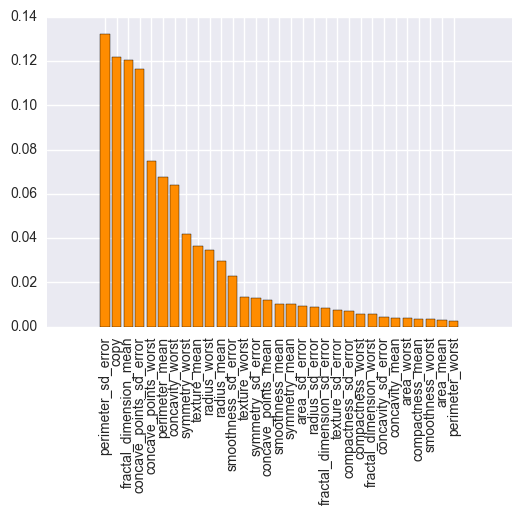

In [105]:
# plot feature importances

importance = pd.DataFrame(importance, index = train_features.columns, columns = ["Importance"])
importance = importance.sort_values('Importance', ascending = False)

x = range(importance.shape[0])
y = importance.ix[:, 0]

labels = importance.index
plt.bar(x, y, align = "center", color = "darkorange")
plt.xticks(rotation = 90)
plt.xticks(range(len(labels)), labels, size = "medium")
plt.show()

#### In the above plot, check for "copy" feature which has 100% correlation with "concave_points_sd_error". Regardless of the multiplication factor the copy and the other feature are among top 6. 